# charts.ipynb

This notebook generates figures that track the fluctuation in various HbA1c measures during the COVID-19 pandemic.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from glob import glob

## Data Import

In [2]:
# Read in input files
li = []

for file in glob('../output/data/input*.csv'):
    if file.split('_')[1] not in ['ethnicity.csv']:
        df_temp = pd.read_csv(file)
        df_temp['date'] = file[21:-4]
        df_temp['hba1c_test'] = 1
        li.append(df_temp)
    
df_input = pd.concat(li, axis=0, ignore_index=False).reset_index(drop=True)

In [3]:
# Segment the data by diabetes status
df_t1dm = df_input.loc[df_input.diabetes_type == 'T1DM']
df_t2dm = df_input.loc[df_input.diabetes_type == 'T2DM']

## Total Number

In [18]:
def create_chart(measure, group, title, df, ax):
    """Creates formatted scatterplots displaying line of best fit and
    correlation coefficients with associated p-values.
    """
    # Create the scatter plot
    sns.lineplot(x='date', y=measure, legend=True,
                 hue=group, data=df, ax=ax, ci=None)
    
    # Set title and make axes labels empty
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')

In [19]:
# Variables by which to subset
subset_vars = ['date','hba1c_test',
               'hba1c_gt_48','hba1c_gt_58',
               'hba1c_gt_64','hba1c_gt_75']

In [29]:
# Monthly total
df_total = df_input[subset_vars].groupby('date').sum().reset_index()
df_total_t1dm = df_t1dm[subset_vars].groupby('date').sum().reset_index()
df_total_t2dm = df_t2dm[subset_vars].groupby('date').sum().reset_index()

In [28]:
# Group by demographics 
def sum_by_group(group):
    sum_input = df_input[[group] + subset_vars].groupby(['date', group]).sum().reset_index()
    sum_t1dm = df_t1dm[[group] + subset_vars].groupby(['date', group]).sum().reset_index()
    sum_t2dm = df_t2dm[[group] + subset_vars].groupby(['date', group]).sum().reset_index()
    return sum_input, sum_t1dm, sum_t2dm

In [30]:
df_age, df_age_t1dm, df_age_t2dm = sum_by_group('age_group')
df_sex, df_sex_t1dm, df_sex_t2dm = sum_by_group('sex')
df_eth, df_eth_t1dm, df_eth_t2dm = sum_by_group('ethnicity')
df_reg, df_reg_t1dm, df_reg_t2dm = sum_by_group('region')
df_imd, df_imd_t1dm, df_imd_t2dm = sum_by_group('imd')
df_ld, df_ld_t1dm, df_ld_t2dm = sum_by_group('learning_disability')
df_mi, df_mi_t1dm, df_mi_t2dm = sum_by_group('mental_illness')

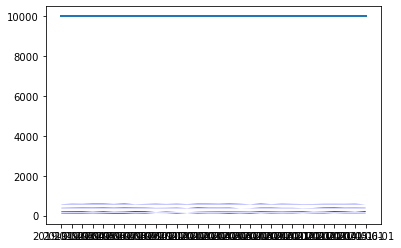

In [34]:
fig, ax = plt.subplots()

ax.plot(df_total.date, df_total.hba1c_test, lw=2)
ax.fill_between(df_total.date, df_total.hba1c_gt_48.min(), 
                df_total.hba1c_gt_48, facecolor='blue', alpha=0.4)
ax.fill_between(df_total.date, df_total.hba1c_gt_58.min(), 
                df_total.hba1c_gt_58, facecolor='blue', alpha=0.6)
ax.fill_between(df_total.date, df_total.hba1c_gt_64.min(), 
                df_total.hba1c_gt_64, facecolor='blue', alpha=0.8)
ax.fill_between(df_total.date, df_total.hba1c_gt_75.min(), 
                df_total.hba1c_gt_75, facecolor='blue', alpha=1)